In [35]:
import time
import os
import cv2
import matplotlib.pyplot as plt
from lib.utilities import *
import numpy as np
import pandas as pd
from scipy.stats import norm, kstest, sem, ttest_ind

import datetime

# investigate probability of crossing controlling for distance to boundary
# (and size of barrel?)

In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/Anna PV PPR/"
# data_dir = 'C:/Users/jjudg/Downloads/'
plt.rcParams.update({'font.size': 13})
#plt.rcParams['figure.figsize'] = [20, 12]

In [48]:
# work with latency data
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
csv_file = data_dir + 'PreLim_PV_STP_Layer4StimOnly_4_2_2024.csv'

# load the all-data CSV dir
df = pd.read_csv(csv_file)
df = df.drop(columns=['Latency_1', 'Latency_2', 'Halfwidth_1', 
                      'Halfwidth_2', 'PeakTime_1', 'PeakTime_2',
                      'Rise_1', 'Rise_2', 'Decay_1', 'Decay_2',
                      'Stim_intensity', 'RLI', 'Cx', 'Trial_x_Time'])
df = df[df["PPR"] > 0]
df = df[df["PPR"] < 2]

for bar in ['0', '1']:
    df2 = df[df['Barrels'] == bar]
    for date in df2['date'].unique():
        slrs = []
        for slr in df2[df2['date'] == date]['Slice_Loc_Run'].unique():
            sl = slr[:2]
            if slr not in slrs:
                slrs.append(slr)
        print('date', len(slrs))
df

date 3
date 5
date 7
date 3
date 5
date 7


,ROI_ID,Amp_1,Amp_2,SNR_1,SNR_2,nPixels,Barrels,Layers,PPR,Slice_Loc_Run,Stim_layer,IPI,date
0,1,0.001240,0.000683,3.48335,1.91849,1,1,4,0.550762,03-01-01,4,20,2022-07-26
1,2,0.001375,0.000704,6.49998,3.32801,1,1,4,0.512007,03-01-01,4,20,2022-07-26
2,3,0.001445,0.000824,7.30323,4.16637,5,Edge,4,0.570476,03-01-01,4,20,2022-07-26
3,4,0.001114,0.000731,4.53138,2.97294,2,1,4,0.656075,03-01-01,4,20,2022-07-26
4,5,0.001375,0.000819,4.93487,2.94083,1,Edge,4,0.595926,03-01-01,4,20,2022-07-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,67,0.006902,0.006908,15.87650,15.89030,2,0,4,1.000866,05-02-07,4,200,2023-06-23
1755,68,0.007524,0.006853,16.59150,15.11340,1,0,4,0.910916,05-02-07,4,200,2023-06-23
1756,69,0.007424,0.007933,19.59830,20.94230,1,0,4,1.068574,05-02-07,4,200,2023-06-23
1757,70,0.007239,0.006950,11.93390,11.45680,1,0,4,0.960016,05-02-07,4,200,2023-06-23


   IPI     Amp_1
0   10  0.005481
1   20  0.003137
2   50  0.003248
3   75  0.004861
4  100  0.003050
5  150  0.005086
6  200  0.004996
   IPI     Amp_2
0   10  0.004787
1   20  0.002020
2   50  0.002020
3   75  0.003027
4  100  0.002204
5  150  0.002966
6  200  0.003090


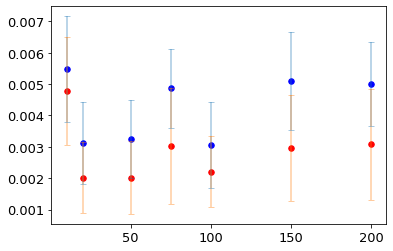

In [29]:
for col, amp in [['blue', 'Amp_1'], ['red', 'Amp_2']]:
    pulse_df_std = df[['IPI', amp]].groupby(by=['IPI']).agg(np.std)
    pulse_df = df[['IPI', amp]].groupby(by=['IPI']).mean()
    pulse_df.reset_index(inplace=True)

    print(pulse_df)
    plt.errorbar(pulse_df['IPI'], # + i * 0.5 - 0.25, 
                 pulse_df[amp], 
                 pulse_df_std[amp], ls='none', 
                 capsize=3, alpha=0.4)
    plt.scatter(pulse_df['IPI'], pulse_df[amp],
                    s=30, color=col)

plt.show()

In [42]:
amp = 'PPR'

pvals = []

# significance tests that PPR < 1
first_ipi_data = np.random.normal(loc=1.0, 
                                    scale=np.average(pulse_df_std['PPR']),
                                    size=1000)
for ipi in pulse_df['IPI']:
    ipi_data = df2[df2['IPI'] == ipi]['PPR']
    
    # one-sided t-test if ipi_data is less than first_ipi_data
    t_stat, p_val = ttest_ind(ipi_data, first_ipi_data, alternative='less', equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

def get_sig_level(x):
    if x < 0.001:
        return '***'
    if x < 0.01:
        return '**'
    if x < 0.05:
        return '*'
    

significance_levels = [get_sig_level(x) for x in pvals]
print('significance tests that PPR < 1', significance_levels)

pvals = []
df0 = df[df['Barrels'] == '0']
df1 = df[df['Barrels'] == '1']

# significance tests that barrel 1 < barrel 0
for ipi in pulse_df['IPI']:
    ipi_data0 = df0[df0['IPI'] == ipi]['PPR']
    ipi_data1 = df1[df1['IPI'] == ipi]['PPR']
    
    # one-sided t-test
    t_stat, p_val = ttest_ind(ipi_data1, ipi_data0, alternative='less', equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

significance_levels = [get_sig_level(x) for x in pvals]
print('significance tests that PPR(1) < PPR(0)', significance_levels)


p_val for IPI 10 : 5.031629374242374e-08
p_val for IPI 20 : 3.518173955830885e-51
p_val for IPI 50 : 2.7501980464648443e-56
p_val for IPI 75 : 2.8453382981513855e-11
p_val for IPI 100 : 2.9223744057975974e-57
p_val for IPI 150 : 2.2426057291160036e-13
p_val for IPI 200 : 1.3298672592258563e-11
significance tests that PPR < 1 ['***', '***', '***', '***', '***', '***', '***']
p_val for IPI 10 : 1.0670888104036437e-07
p_val for IPI 20 : 8.377365485120737e-11
p_val for IPI 50 : 6.307639243461494e-06
p_val for IPI 75 : 1.205123424540656e-05
p_val for IPI 100 : 0.00036219210797049545
p_val for IPI 150 : 2.6166041238783184e-06
p_val for IPI 200 : 3.604202108412528e-07
significance tests that PPR(1) < PPR(0) ['***', '***', '***', '***', '***', '***', '***']


   IPI       PPR
0   10  0.992089
1   20  0.793934
2   50  0.729818
3   75  0.812945
4  100  0.773361
5  150  0.710368
6  200  0.804792
   IPI       PPR
0   10  0.768019
1   20  0.601703
2   50  0.598177
3   75  0.435752
4  100  0.702284
5  150  0.424639
6  200  0.464633


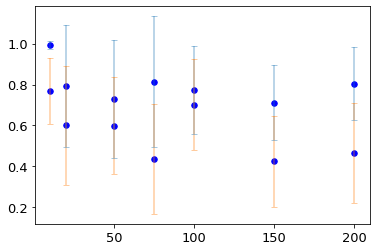

In [43]:

# plot PPR for each barrel
for bar in ['0', '1']:
    df2 = df[df['Barrels'] == bar]
    pulse_df_std = df2[['IPI', amp]].groupby(by=['IPI']).agg(np.std)
    pulse_df = df2[['IPI', amp]].groupby(by=['IPI']).mean()
    pulse_df.reset_index(inplace=True)



    print(pulse_df)
    plt.errorbar(pulse_df['IPI'], # + i * 0.5 - 0.25, 
                    pulse_df[amp], 
                    pulse_df_std[amp], ls='none', 
                    capsize=3, alpha=0.4)
    plt.scatter(pulse_df['IPI'], pulse_df[amp],
                    s=30, color=col)

plt.show()